# 2 Estimating an Interest Rate Rule

### 2(a) Download and Plot Data

In [18]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Task 1: 
# Set start and end dates
start_date = '1985-01-01'
end_date = '2007-12-31'

# Download data from FRED
fred_api_key = '02493cdc4cc648a55d204499ff1bf083'  # Replace with your FRED API key
data = web.DataReader(['FEDFUNDS','GDPC1','GDPPOT','CPIAUCSL'], 'fred', start=start_date, end=end_date, api_key=fred_api_key)

In [19]:
# aggregate data to quarterly
data = data.resample('QS').mean()   

# Calculate inflation rate (percentage change in CPI)
data['CPI Inflation'] = data['CPIAUCSL'].pct_change(4) * 100

# Calculate output gap
data['Output Gap'] = np.log(data['GDPC1'] / data['GDPPOT']) * 100

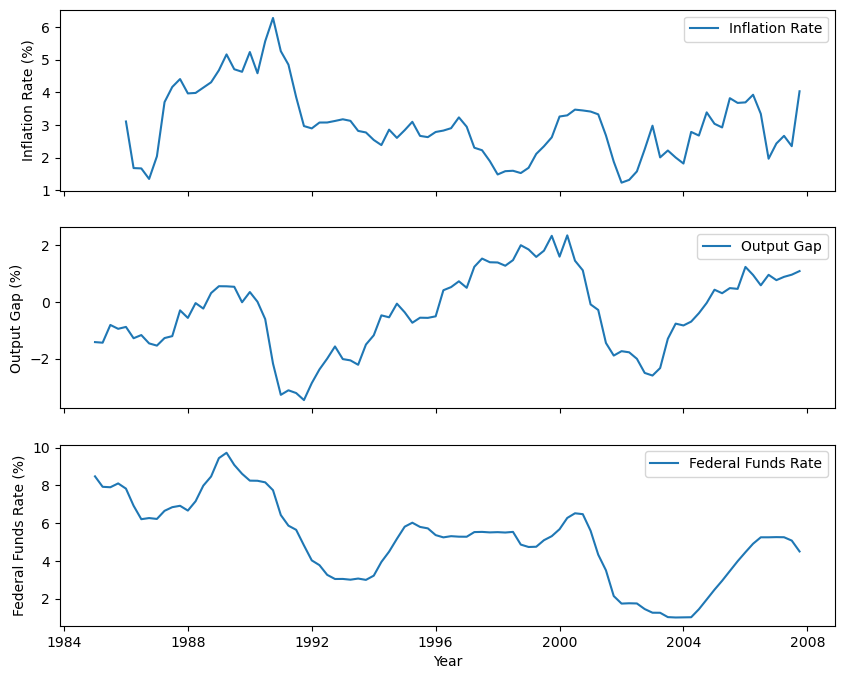

In [20]:
# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(data.index, data['CPI Inflation'], label='Inflation Rate')
axs[0].set_ylabel('Inflation Rate (%)')
axs[0].legend()

axs[1].plot(data.index, data['Output Gap'], label='Output Gap')
axs[1].set_ylabel('Output Gap (%)')
axs[1].legend()

axs[2].plot(data.index, data['FEDFUNDS'], label='Federal Funds Rate')
axs[2].set_ylabel('Federal Funds Rate (%)')
axs[2].legend()

plt.xlabel('Year')
plt.show()

### 2(b) Estimate the interest rate rule by OLS

In [21]:
import statsmodels.api as sm

# Prepare the data for OLS regression
data['FEDFUNDS_Lag'] = data['FEDFUNDS'].shift(1)
data = data.dropna()

X = data[['FEDFUNDS_Lag', 'CPI Inflation', 'Output Gap']]
y = data['FEDFUNDS']
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Run the OLS regression
model = sm.OLS(y, X).fit()

# Print the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               FEDFUNDS   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     797.2
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           1.40e-61
Time:                        10:28:00   Log-Likelihood:                -41.935
No. Observations:                  88   AIC:                             91.87
Df Residuals:                      84   BIC:                             101.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0693      0.135      0.512

### 2(c) Why are estimates biased?

Monetary policy shocks affect both the error term and the RHS variables --- inflation and the output gap. Intuitively, we cannot estimate the systematic reaction function from MP shocks.

### 2(d) Which direction does the bias go?

We typically believe that a contractionary monetary policy shock (higher $v_t$) would reduce the output gap and inflation. This would create a negative correlation between these variables and the error term and bias the coefficient downwards.

# 3 Estimating an Interest Rate Rule in the NK model

## 1 Set up the New Keyensian model

The linearized New Keynesian model has the following equilibrium conditions

$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
\hat{y}_t +\sigma[\hat{i}_t-\{\hat{\pi}_{t+1}\}]+E_t\{\hat{y}_{t+1}\}
\\
\hat{\pi}_t - \kappa \hat{y}_t -\beta E_t \{\hat{\pi}_{t+1}\} - \hat{u}_t
\\
\hat{i}_t - \phi_\pi\hat{\pi}_t- \bar{i}_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0  \end{pmatrix},
\qquad t = 0, 1, \dots 
\tag{1}
$$

#### The NK DAG
The 3 equations of the RBC model can be organized as three blocks which form a DAG in two unknowns $U = \{y\}$ and one target, the Euler equation: 
$$
\textbf{H}_t(U, Z) = 0
$$

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sequence_jacobian import simple, create_model

@simple
def nkpc(pi, u, beta, kappa):
    y = 1 / kappa * (pi - beta * pi(+1) - u)
    return y

@simple
def central_bank(pi, ibar, phi_pi):
    i = phi_pi * pi + ibar
    return i

@simple
def mkt_clearing(y, i, pi, sigma):
    euler = y + sigma * (i - pi(+1)) - y(+1)
    r = i - pi(+1)
    c = y
    return euler, r, c

Next, we combine the 3 simple blocks to get the linear NK model. 

In [23]:
nk = create_model([nkpc, central_bank, mkt_clearing], name="NK")

print(nk)
print(f"Blocks: {nk.blocks}")

<Model 'NK'>
Blocks: [<SimpleBlock 'central_bank'>, <SimpleBlock 'nkpc'>, <SimpleBlock 'mkt_clearing'>]


### DAG visualization (not required)

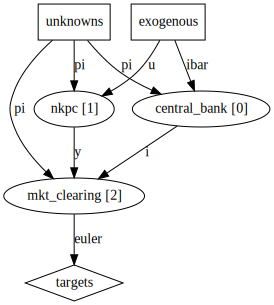

In [24]:
from sequence_jacobian.utilities.drawdag import drawdag

unknowns = ['pi']
targets = ['euler']
inputs = ['u', 'ibar']

drawdag(nk, inputs, unknowns, targets, save="nk.png")

### Steady state

Since we linearize around the  steady state, the linearized variables by definition are 0 in the steady state.

In [25]:
# initial parameters
sigma = 1
beta = 0.99
phi_pi = 1.5
kappa = 0.03
sigmai = 0.1
sigmau = 0.01
rho = 0.8

# steady state value
calibration = {'u': 0, 'ibar': 0, 'y': 0, 'c': 0, 'r': 0, 'i': 0, 'sigma': sigma, 'beta': beta, 'phi_pi': phi_pi, 'kappa': kappa}

# solve for steady state (we know it, but running this routine helps us check for mistakes)
unknowns_ss = {'pi': 0}
targets_ss = { "euler": 0}

ss = nk.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="broyden_custom")

# checking that we are in the steady state that we expect
assert np.allclose(ss['pi'], 0)
assert np.allclose(ss['euler'], 0)

### Linearized solution

The linearized impulse responses of the model are fully characterized by the general equilibrium Jacobians $G = H_U^{-1}H_Z$.

In [26]:
G = nk.solve_jacobian(ss, unknowns, targets, inputs, T=300)

### 3(a) IRFs

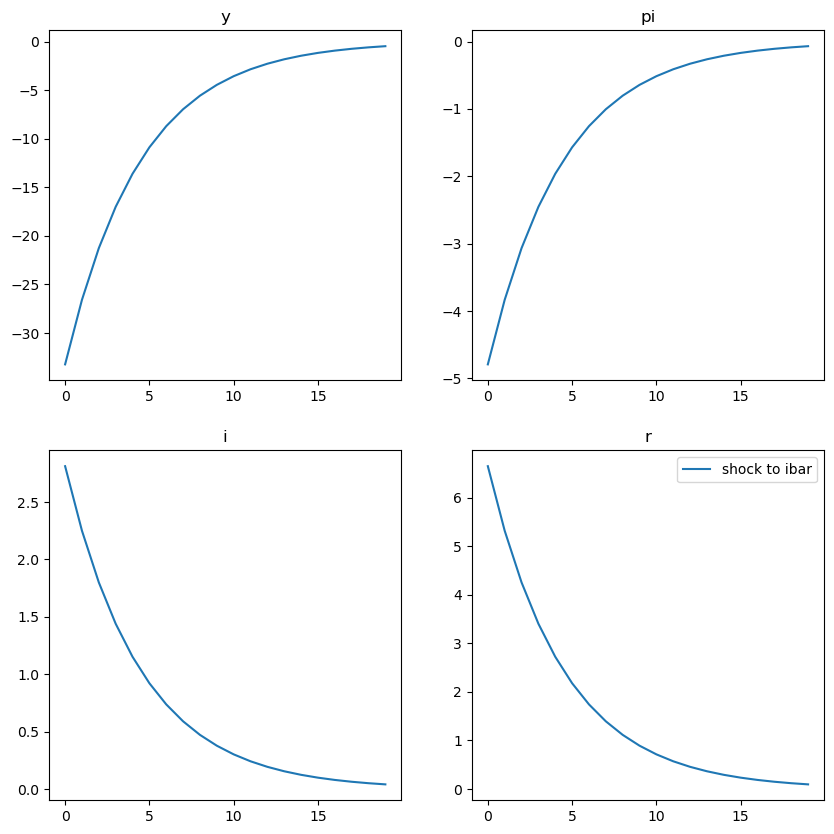

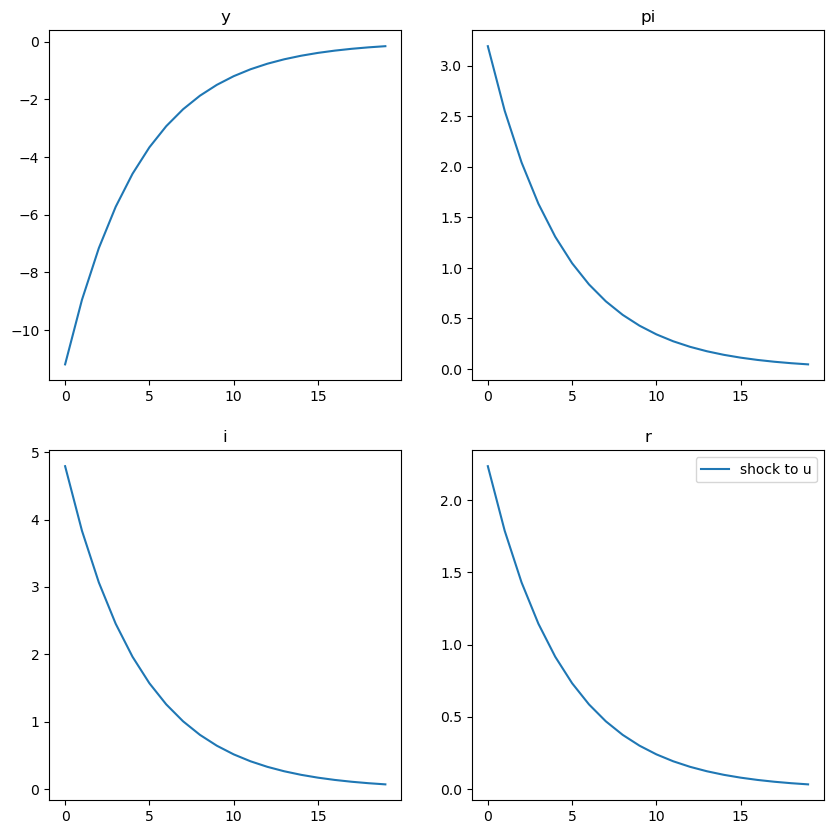

In [27]:
T, Tplot, rho = 300, 20, 0.8
impact = {'u': sigmau, 'ibar': sigmai}

dshock = {}
for exog in ['u', 'ibar']:
    dshock[exog] = impact[exog] * rho**np.arange(T)

plotset = ['y', 'pi', 'i', 'r']

for exog in ['ibar', 'u']:
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i, var in enumerate(plotset):
        irf = 100 * (G[var][exog] @ dshock[exog])[:Tplot]
        axi = ax[i // 2, i % 2]
        axi.plot(irf, label="shock to " + exog)
        axi.set_title(f"{var}")
    axi.xlabel = "quarters"
    axi.ylabel = "% deviation"
    axi.legend()
    plt.show()

### 3(b) Intution for shocks

See lecture slides

### 3(c) Simulation and plot

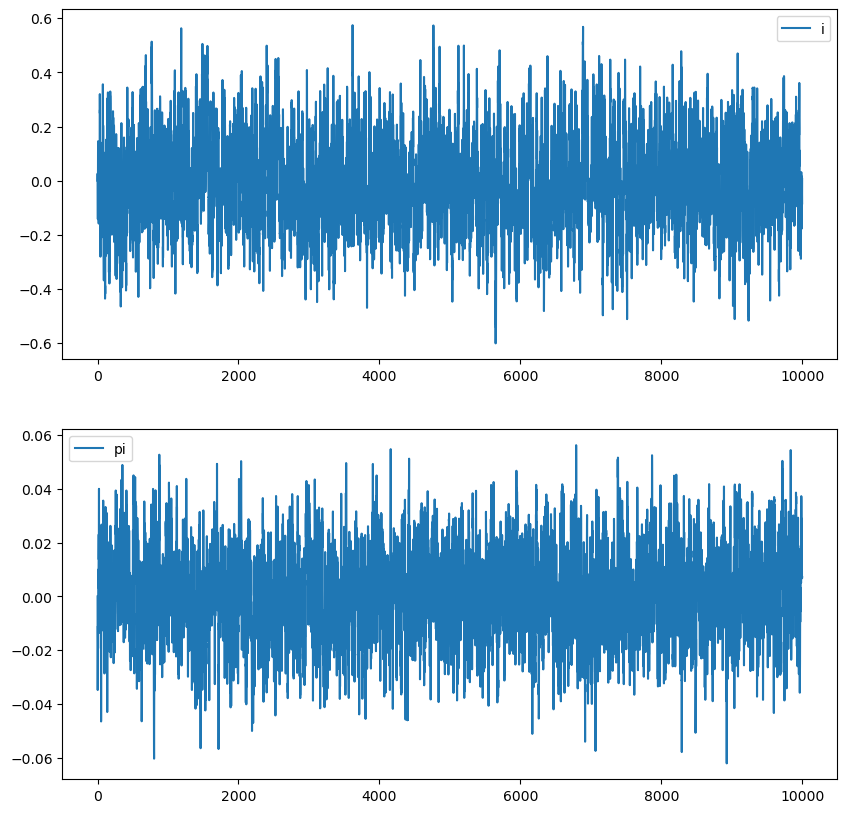

In [28]:
# draw random shocks for ibar and rn of length 1000 from a normal distribution with mean 0 and standard deviation 0.01
simullen = 10000
shocks = np.random.normal(0, 1, (simullen + T, 2))

# feed shocks into the ar1 process with persistence rho
exog = np.zeros((simullen + T, 2))
for t in range(1, simullen):
    exog[t, :] = rho * exog[t - 1, :] + shocks[t, :]

# scale with standard deviation
exog = exog * np.array([sigmai, sigmau])

# use G matrix to get simulated values for i, pi
simul = np.zeros((simullen + T, 2))
for t in range(simullen):
    simul[t:t+T, 0] = G['i']['ibar'][:, 0] * exog[t, 0] + G['i']['u'][:, 0] * exog[t, 1]
    simul[t:t+T, 1] = G['pi']['ibar'][:, 0] * exog[t, 0] + G['pi']['u'][:, 0] * exog[t, 1]

# plot simulated values
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(simul[:simullen, 0], label='i')
ax[1].plot(simul[:simullen, 1], label='pi')
ax[0].legend()
ax[1].legend()
plt.show()

### 3(d) Estimate the interest rate rule

In [29]:
# regress nominal rate = beta * inflation and report OLS coefficient for beta
from scipy.stats import linregress

beta_hat = linregress(simul[:simullen, 1], simul[:simullen, 0]).slope
print(f"Estimated beta: {beta_hat}")

Estimated beta: -1.4767679174955215


### 3(e) why not the true parameter?

See 2(c) above. 

### 3(f) What data do you need to identify $\phi_\pi$?

We need the supply shocks as instruments.

### 3(g) Implement the procedure

In [30]:
# reduced form regression of i on u
beta_rf = linregress(exog[:simullen, 1], simul[:simullen, 0]).slope

# fs regression of pi on u
beta_fs = linregress(exog[:simullen, 1], simul[:simullen, 1]).slope

# report iv coefficient
iv = beta_rf / beta_fs
print(f"IV coefficient: {iv}")

IV coefficient: 1.6180706220773677


### 3(h) Does it work with more general interest rate rule

No we would need another instrument. There is fixed linear relationship between $\pi$ and $y$ conditional on the $u$ shock so the two variables would be collinear. Intuitively, we do not know if the central bank responds to the inflation or the output gap part of the cost-push shock IRF.